In [ ]:
!pip install sktime[all_extras]

In [54]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import os
os.chdir("/content/drive/MyDrive/Kaggle Competitions/Rossmann Store Sales")
import pandas as pd
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA

In [26]:
train = pd.read_csv("train.csv", index_col=2)
test = pd.read_csv("test.csv", index_col=2)


<ipython-input-26-8cb986f67494>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv", index_col=2)


In [ ]:
tst_1 = test[test['Store']==1]
s_1 = train[train['Store']==1]['Sales']
s_1.head(10)

In [43]:
idx = pd.to_datetime( s_1.index, format="%Y-%m-%d" ).to_period("D")
s_1.index = idx

In [ ]:
s_1 = s_1.sort_index()
s_1.head(4)

In [ ]:
y = s_1
y_train, y_test = temporal_train_test_split(y, test_size=48)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
plt.show()

### ETS

/usr/local/lib/python3.10/dist-packages/sktime/forecasting/base/adapters/_statsmodels.py:54: UserWarning: Warning: time series is not strictly positive, multiplicative components are ommitted
  self._fit_forecaster(y, X)


887.8928699234333


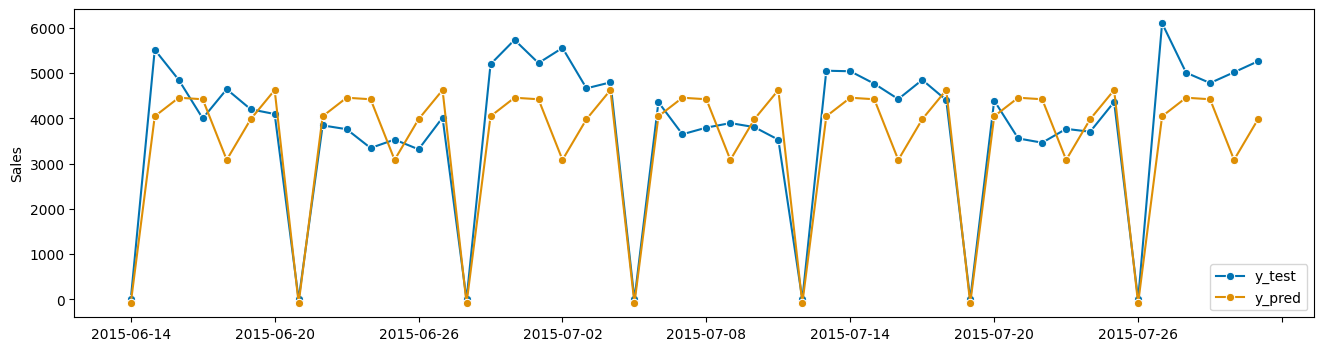

In [50]:
fh = ForecastingHorizon(y_test.index,is_relative=False)
forecaster = AutoETS(auto=True, sp=7)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_test, y_pred, labels=["y_test", "y_pred"])
print(mean_squared_error(y_test, y_pred,square_root=True))

### ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=4.29 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=16157.845, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=16040.356, Time=0.76 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=15977.614, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=17557.500, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=16144.657, Time=0.16 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=15972.082, Time=0.75 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=16100.561, Time=0.29 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=15721.533, Time=3.05 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=15442.155, Time=2.05 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=15572.053, Time=4.25 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(0,0,2)(2,0,0)[7] intercept   : AIC=15491.675, Time=2.57 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=15976.635, Time=0.99 sec
 ARIMA(1,0,2)(2,0,0)[7] interce

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(0,0,1)(2,0,0)[7]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(0,0,1)(2,0,0)[7]             : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,1)(2,0,0)[7] intercept
Total fit time: 29.683 seconds
1096.6370071952933


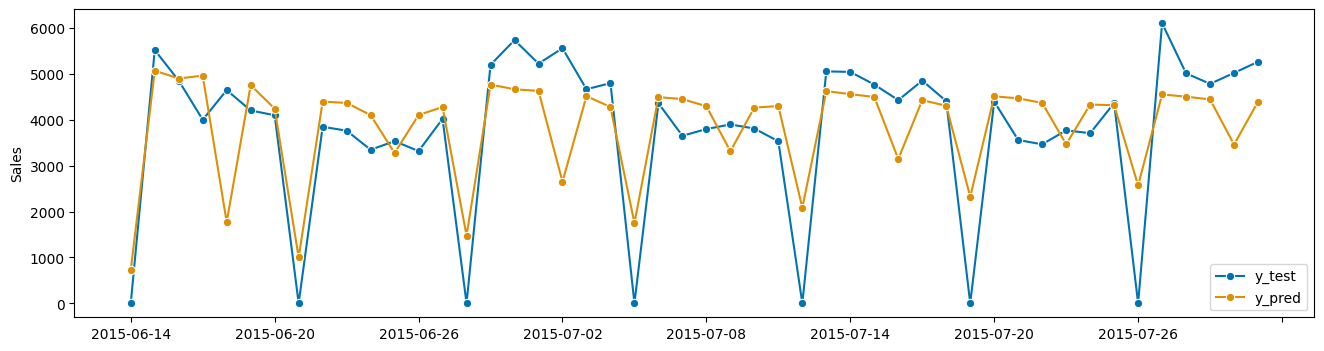

In [53]:
forecaster = AutoARIMA(sp=7, d=0, max_p=3, max_q=3, suppress_warnings=True, trace=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_test, y_pred, labels=["y_test", "y_pred"])
print(mean_squared_error(y_test, y_pred,square_root=True))

### Random Forest

In [55]:
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV,SlidingWindowSplitter
regressor = RandomForestRegressor(random_state=23)
forecaster = make_reduction(regressor, window_length=10, strategy="recursive")
param_grid = {"window_length": [7,10, 12, 15]}
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.9), window_length=20)
gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cv, param_grid=param_grid)
gscv.fit(y_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(initial_window=804,
                                                 window_length=20),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=23)),
                        param_grid={'window_length': [7, 10, 12, 15]})

404.8713457383716


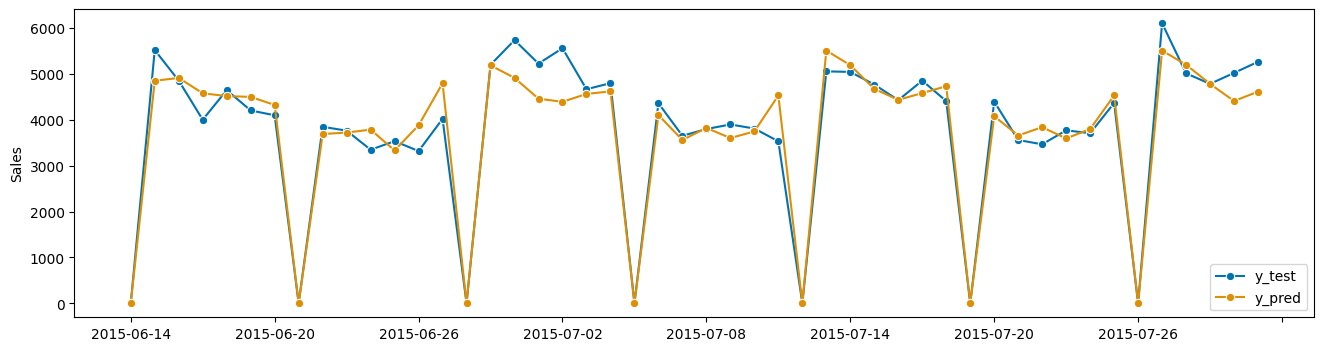

In [57]:
y_pred = gscv.predict(fh)
plot_series(y_test, y_pred, labels=["y_test", "y_pred"])
print(mean_squared_error(y_test, y_pred,square_root=True))